# Clustering Algorithms

Clustering is a technique used in both data mining and machine learning to group similar data points together in order to identify patterns in their distributions. The task of clustering data can be carried out using a number of algorithms. Here we outline implementations of CURE (Clustering Using REpresentatives), DBSCAN (Density-based spatial clustering of applications with noise), hierarchical and k-means clustering.

The algorithms defined here work based on distinct clustering methodologies namely; connectivity-based, centroid-based or density-based models.

-   Connectivity models, which include hierarchical and CURE, cluster data based on distances between individual data points.
-   Centroid models such as k-means define clusters based on distances from single points which represent the cluster.
-   Density-based models such as DBSCAN define clusters based on clusters being within a certain distance of each other and in defined concentrations.

Each algorithm works by iteratively joining, separating or reassigning points until the desired number of clusters have been achieved. The process of finding the correct cluster for each data point is a case of trial and error, where parameters must be altered in order to find the optimum solution.

### Dependencies

In this notebook we look in depth at each clustering algorithm provided in the ML-Toolkit. To run the below notebook, the following dependencies are required.
```
- embedPy
- matplotlib
- scipy
- scikit-learn
- pyclustering
```

### Load libraries and scripts

In the below cell, the clustering section of the ML-Toolkit is loaded in, along with `graphics.q`, a script which the contains functions required to plot hierarchical algorithms.

In [1]:
\l ml/ml.q
.ml.loadfile`:clust/init.q
\l graphics.q

Throughout the notebook, we visualize data using the python `matplotlib` library as well as datasets from the python `pyclustering` samples library. All of the necessary functions provided in each can be imported using embedPy as shown below.

In [17]:
plt:.p.import`matplotlib.pyplot
.p.import[`mpl_toolkits.mplot3d]`:Axes3D;
fcps:.p.import[`pyclustering.samples.definitions]`:FCPS_SAMPLES
smpl:.p.import[`pyclustering.samples.definitions]`:SIMPLE_SAMPLES
read:.p.import[`pyclustering.utils]`:read_sample
skds:.p.import`sklearn.datasets
hc:  .p.import[`scipy.cluster]`:hierarchy

---

## CURE (Clustering Using REpresentatives)

CURE clustering is a technique used to deal with datasets containing outliers and clusters of varying sizes and shapes. Each cluster is represented by a specified number of representative points. These points are chosen by taking the the most scattered points in each cluster and shrinking them towards the cluster centre by a fixed amount, known as the compression.

In the implementation below, a k-d tree is used in order to store the representative points of each cluster (more information [here](https://code.kx.com/v2/ml/toolkit/clustering/kdtree)). Both q and C implementations of the tree are available and are specified as an argument.

### Inputs

CURE is called using the function `.ml.clust.cure` which takes the followning arguments:
* `d` is data points in matrix form
* `k` is the number of clusters
* `r` is the number of representative points
* `i` is a dictionary of inputs in the form:
    - `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
    - `c` is the compression
    - `b` is a boolean, `1b` for C, `0b` for q
    - `s` is a boolean, `1b` to return a dictionary, `0b` to return a table of clusters

**Note**: `()` can also be used for `i`. This will use the default dictionary, where: `df = e2dist`, `c = 0`,`b = 0b` and `s = 0b`.

### Examples

The below creates a dataset containing points belonging to 4 distinct clusters. Most clustering algorithms do not perform well when presented with concentric circle. By using representative points and compression, CURE is able to perform well when applied to these kind of datasets.

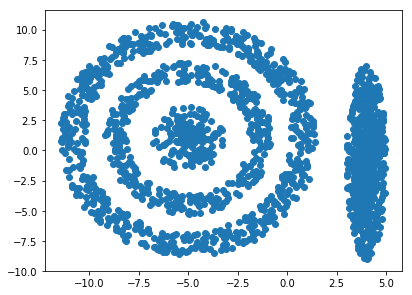

In [3]:
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
d1 :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
d1,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
d1@:neg[2000&count d1]?count d1
plt[`:scatter][;]. flip d1;
plt[`:show][];

22556 618000


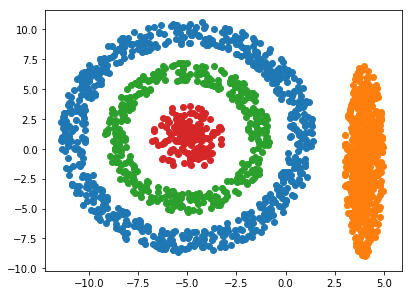

In [4]:
\ts r1:.ml.clust.cure[d1;4;50;()]
{plt[`:scatter][;]. flip x}each exec pts by clt from r1;
plt[`:show][];

#### Adding compression

In cases where the dataset provided contains outliers or has clusters of varying sizes and shapes, adding compression can be used to improved the clusters produced.

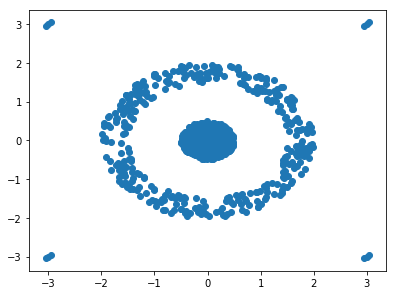

In [5]:
d2:read[fcps`:SAMPLE_TARGET]`
plt[`:scatter][;]. flip d2;
plt[`:show][];

542 286768


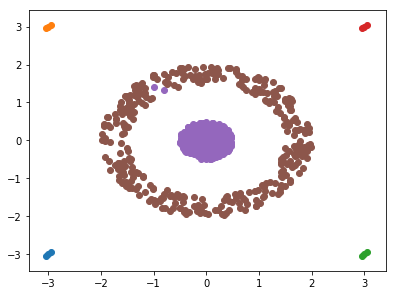

In [6]:
\ts r2:.ml.clust.cure[d2;6;5;()]
{plt[`:scatter][;]. flip x}each exec pts by clt from r2;
plt[`:show][];

Points in the two most central clusters have been assigned to clusters incorrectly. This can be improved by adding a small compression of `0.1`.

58 287648


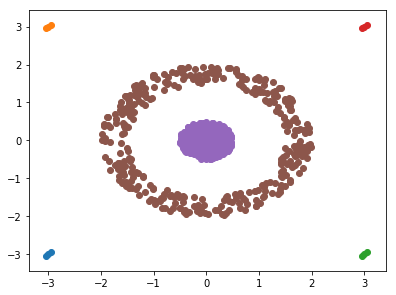

In [7]:
\ts r2c:.ml.clust.cure[d2;6;5;`c`b!(.1;1b)]
{plt[`:scatter][;]. flip x}each exec pts by clt from r2c;
plt[`:show][];

---

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm groups points together that are closely packed in areas of high-density. Any points in low-density regions are seen as outliers.

Unlike other clustering algorithms which require the user to input the desired number of clusters, DBSCAN will decide how many clusters are in the dataset based the minimum number of points required per cluster and the epsilon radius, both given by the user.

### Inputs

DBSCAN is called using the function `.ml.clust.dbscan` which takes the followning arguments:
* `d` is data points in matrix form
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `p` is minimum number of points required in a given neighbourhood for it to be classified as a cluster
* `e` is the epsilon radius, the distance from each point within which points are defined as being in the same cluster

### Example

Below shows how DBSCAN can be used to cluster data in odd shapes, such a crescent moons. Distance based models would struggle to correctly classify points in the below datasets as clusters are in close proximity and so points could easily be included in the wrong cluster. However, density based DBSCAN is able to distinguish between the clusters given that points in each are densely packed.

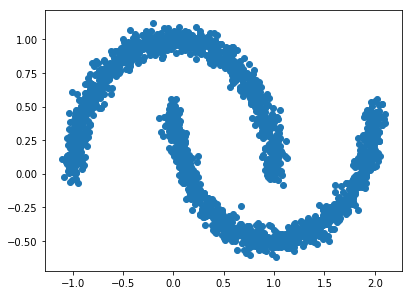

In [8]:
d3:skds[`:make_moons][`n_samples pykw 2000;`noise pykw 0.05]`
plt[`:scatter][;]. flip d3@:0;
plt[`:show][];

409 20944928


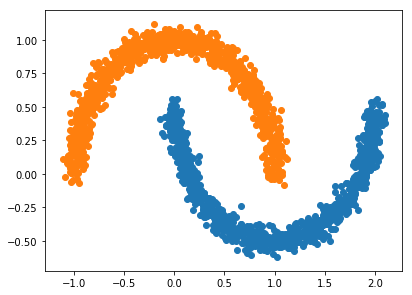

In [9]:
\ts r3:.ml.clust.dbscan[d3;`e2dist;6;.05]
{plt[`:scatter][;]. flip x}each exec pts by clt from r3;
plt[`:show][];

---

# Hierarchical

As the name suggests, hierarchical clustering algorithms create a hierarchy of clusters. The implementation described here follows an agglomerative approach, where each data point is initially treated as its own cluster. 

There are 5 possible linkages in hierarchical clustering: single, complete, average, centroid and ward. Euclidean or manhattan distances can be used for with each linkage, except for ward which only works with euclidean squared distances. Additionally, a k-d tree has been used for the single and centroid implementations.

At each step, the two closest clusters (defined by the linkage) are merged until only one cluster remains, which contains all of the data points. Results are usually represented by a dendrogram, used to suggest the “appropriate” number of clusters in the data. 

### Inputs

To create a dendrogram, the function `.ml.clust.dgram` is called which takes the followning arguments:
* `d` is data points in matrix form
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `lf` is the linkage function as a symbol: `` `single`complete`average`centroid`ward ``

Given that dendrograms do not actually return lists of clustered data points, the function `ml.clust.hc` has been provided to allow users to define the number of clusters to return using the following parameters:
* `d` is data points in matrix form
* `k` is the number of clusters
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `lf` is the linkage function as a symbol: `` `single`complete`average`centroid`ward ``

### Examples

For simplicity we only showcase some of the hierarchical linkages below. The function `plot` has been used to plot the clustered data and dendrograms for example.

In the first case shown below we use ward linkage, which can only be used in conjunction with squared euclidean distances.

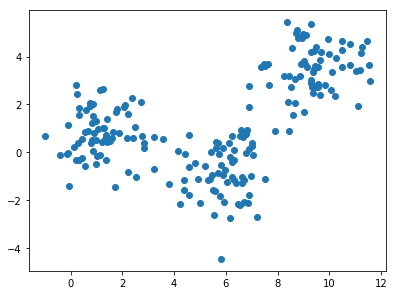

In [14]:
d4:skds[`:make_blobs][`n_samples pykw 200;`random_state pykw 449]`
plt[`:scatter][;]. flip d4@:0;
plt[`:show][];

47 53968


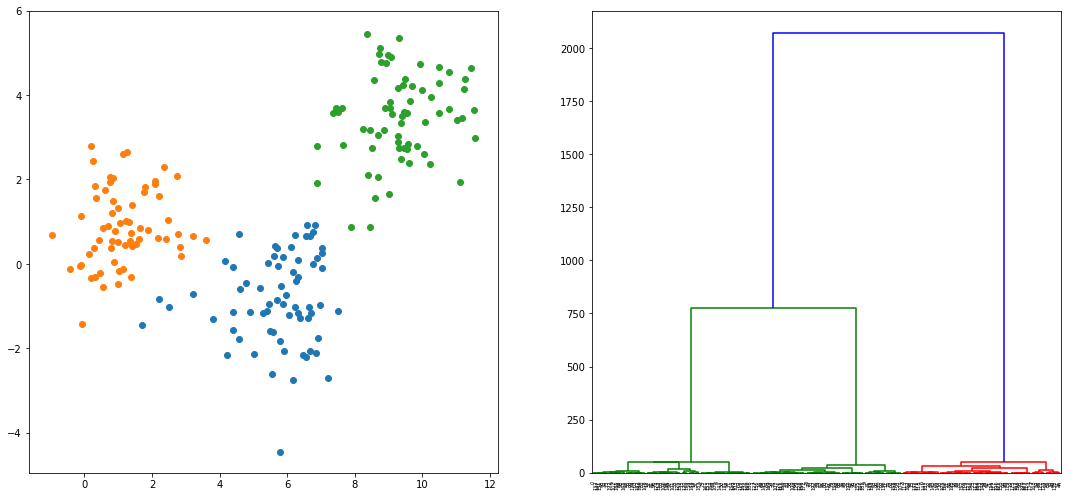

In [20]:
\ts r4:.ml.clust.hc[d4;3;`e2dist;`ward;0b]
plot[d4;3;`e2dist;`ward;()] /can pass in `cluster`dgram or () to plot both

Below we use single linkage to cluster dataset containing clusters of concentric circles defined earlier in the notebook. It is clear that single linkage performs well with circles, similarly to CURE.

6048 597520


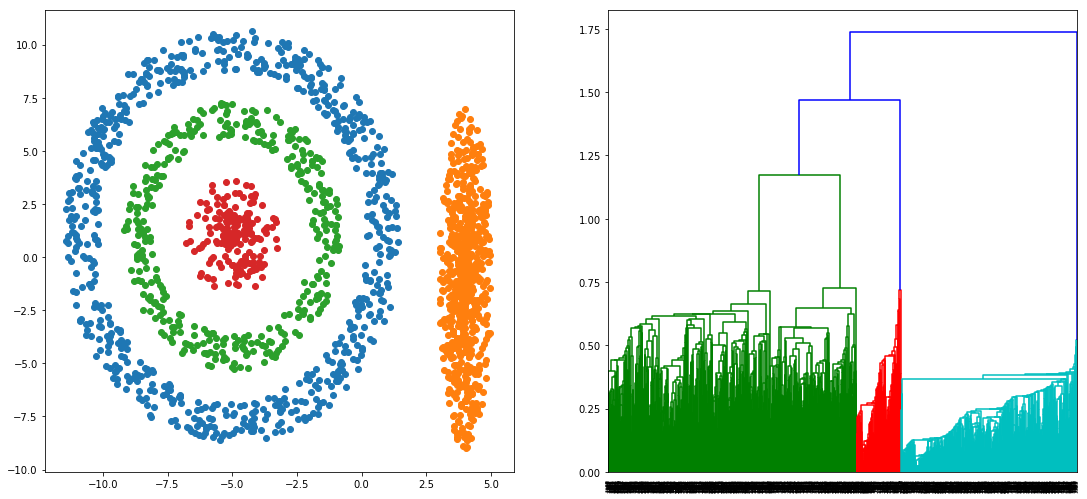

In [21]:
\ts r5:.ml.clust.hc[d1;4;`mdist;`single;0b]
plot[d1;4;`mdist;`single;()]

---

# K-Means

K-means clustering begins by selecting k data points as cluster centres and assigning data to the cluster with the nearest centre. The algorithm follows an iterative refinement process which will run n times, updating the cluster centers and assigned points during each iteration.

### Inputs

K-means is called using the function `.ml.clust.kmeans` which takes the followning arguments:
* `d` is data points in matrix form
* `k` is the number of clusters
* `n` is the number of iterations
* `i` is a boolean flag indicating the initialisaton type: both select k points from the dataset as cluster centres, `1b` initialises the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm or `0b` selects k random points
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``

### Example

Below shows a dataset with no structure. K-means is able to cluster this dataset into even clusters compared to other algorithms.

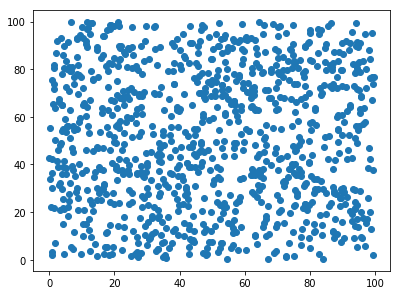

In [22]:
d6:1000 2#2000?100.
plt[`:scatter][;]. flip d6;
plt[`:show][];

70 154768


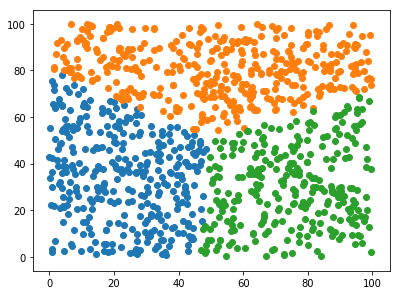

In [23]:
\ts r6:.ml.clust.kmeans[d6;3;100;1b;`e2dist]
{plt[`:scatter][;]. flip x}each exec pts by clt from r6;
plt[`:show][];

---